In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt
from scipy.integrate import quad

from functools import partial


sns.set(rc={'figure.figsize':(12, 9)})
np.random.seed(12122012)

In [2]:
def plot_on_theta(fns, title, labels, figsize=(8, 8)):
    if type(fns) is not list:
        fns = [fns]
    
    if type(labels) is not list:
        labels = [labels]
        
    
    theta = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=figsize)
    
    ax.set_xlim(0, 1)
    
    for n, fn in enumerate(fns):
        ax.plot(theta, fn(theta), label=labels[n])
        
    
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel(r"$\theta$")

    return fig, ax
    

### Morris & Shill (1998, AER)

Implementation of the model by Morris and Shill on speculative attacks. The main feature is the avoidance of sunspot equilibria.

#### Economy

- $\theta \sim U[0, 1]$ - fundamentals of the economy
- $f(\theta); f'(\theta) > 0$ - natural exchange rate
- $\overline{e} \geq f(\theta) \ \forall \theta$ - pegged exchange rate

#### Speculators

- $\pi_s = \overline{e} - f(\theta) - t$ - payoff of short selling if successful

This implicitly defines $\overline{\theta}: \pi_s > 0 \implies f(\overline{\theta}) < \overline{e} - t$

In [3]:
f = lambda theta: np.power(theta, 1.85)
t = 0.4
e_bar = f(1) + 0.05

In [4]:
theta_bar = opt.root(lambda th: e_bar - f(th) - t, 0.5).x[0]

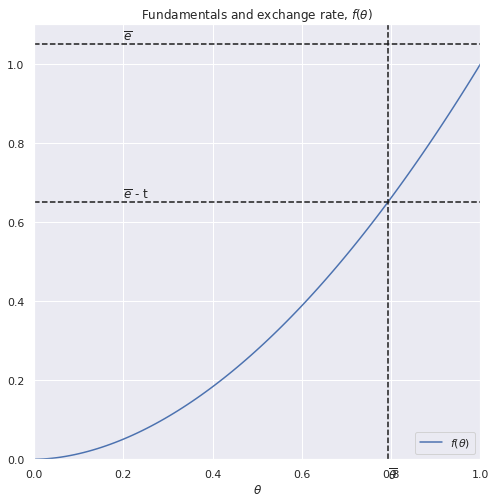

In [5]:
fig, rax = plot_on_theta(
    f, title=r"Fundamentals and exchange rate, $f(\theta)$",
    labels=r"$f(\theta)$"
)

rax.axhline(e_bar, linestyle='--', c='k')
rax.text(0.2, e_bar + 0.01, r"$\overline{e}$")

rax.axhline(e_bar - t, linestyle='--', c='k')
rax.text(0.2, e_bar - t + 0.01, r"$\overline{e}$ - t")

rax.axvline(theta_bar, linestyle='--', c='k')
rax.text(theta_bar, -0.05, r"$\overline{\theta}$")
rax.set_ylim(0, e_bar + 0.05)


fig.show()

#### Government

- $\pi_G = v - c(\alpha, \theta)$ - payoff of defending the peg

this implicitly defines $\underline{\theta}: \pi_G > 0 \implies c(\alpha, \underline{\theta}) < v$

In [6]:
V = 0.4
c = lambda alpha, theta: (alpha + (1-alpha)*V*1.5)*np.exp(-(1.7-alpha)*theta)

c_0 = partial(c, 0)
c_1 = partial(c, 1)

In [7]:
theta_under = opt.root(lambda th: c_0(th) - V, 0.5).x[0]

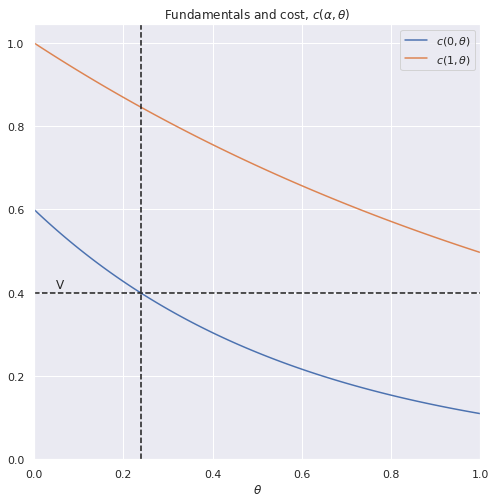

In [8]:
fig, ax = plot_on_theta(
    [c_0, c_1],
    title=r"Fundamentals and cost, $c(\alpha, \theta)$",
    labels=[r"$c(0, \theta)$", r"$c(1, \theta)$"]
)

ax.set_ylim(0, None)

ax.axhline(V, linestyle='--', c='k')
ax.text(0.05, V + 0.01, "V")

ax.axvline(theta_under, linestyle='--', c='k')
# ax.text(theta_under, -0.05, r"$\theta_{u}$")

fig.show()

#### Three areas

This creates three areas:

- $\theta < \underline{\theta} \implies$ no defence of the peg
- $\underline{\theta} < \theta < \overline{\theta} \implies$ defence depends on $\alpha$
- $\theta > \overline{\theta} \implies$ no attack

### Game theory approach - imperfect information over $\theta$

Let $N$ be the number of speculators,

- $\theta \sim U[0, 1]$
- $\mathbf{x}_N \sim \theta + U[- \epsilon, \epsilon]$
- $\alpha = \pi_s(\mathbf{x}_N)$

In [9]:
eps = 0.2

In [10]:
def signal_sampling(speculators = 100):
    theta = np.random.uniform(0, 1)
    x = np.random.uniform(-eps, eps, speculators) + theta
    
    return x

Consider then the proportion of speculators that forces the government to abandon the peg. Namely we can define it as 

\begin{align}
    a(\theta) = \{ \alpha: c(\alpha, \theta) = v\}
\end{align}

Then one can define the proportion of speculators that do attack the currency as

\begin{align}
    s(\theta, \pi) = \frac{1}{2 \cdot \epsilon} \int^{\theta + \epsilon}_{\theta-\epsilon} \pi(x) dx
\end{align}

and we can trivially define

\begin{align}
    A(\pi) = \{s(\theta, \pi) \geq a(\theta) | \theta \}
\end{align}

In [11]:
def a_mass(theta):
        
    sol = opt.root(lambda alpha: c(alpha, theta) - V, 0.5).x[0]
    
    if sol < 0:
        return 0
    
    return sol

a_mass = np.vectorize(a_mass, otypes=[np.float])

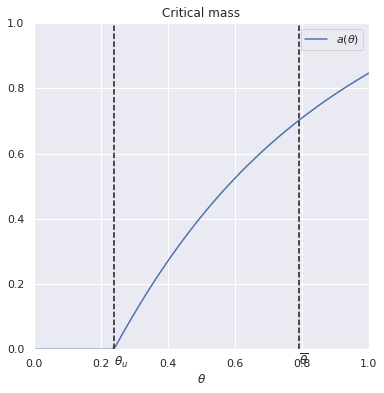

In [12]:
fig, ax = plot_on_theta(
    a_mass,
    title=r"Critical mass",
    labels=r"$a(\theta)$",
    figsize=(6,6)
)

ax.set_ylim(0, 1)

ax.axvline(theta_under, linestyle='--', c='k')
ax.text(theta_under, -0.05, r"$\theta_{u}$")

ax.axvline(theta_bar, linestyle='--', c='k')
ax.text(theta_bar, -0.05, r"$\overline{\theta}$")

fig.show()

Now one has to find $\pi(x)$. In a symmetric Bayesian manner and using the regulraity assumption that

\begin{align} 
    \pi(x) \geq \pi'(x) \implies A(\pi) \supseteq A(\pi')
\end{align}

one can show that there exists a $k$ such that

\begin{align}
    I_k(x) = \begin{cases} 
        1 &if \ x < k  \\
        0 &if \ x \geq k
    \end{cases}
\end{align}

One can then, focusing on the monotonicy and the payoff of agents, show that in equilibrium

\begin{align}
    s(\theta | I_x) = \begin{cases}
        1 &if \ \theta < x^* - \epsilon \\
        \frac{1}{2} - \frac{1}{2 \cdot \epsilon} \cdot (\theta - x^*) \ &if \theta \in x^* + [-\epsilon, \epsilon] \\
        0 &if \ \theta > x^* + \epsilon
    \end{cases}
\end{align}

In [13]:
def step_decision(x_star, eps):
    
    @np.vectorize
    def s(theta):
        if theta < x_star - eps:
            return 1.
        
        if theta > x_star + eps:
            return 0.
        
        return 0.5 - (theta - x_star)/(2*eps)
    
    return s

In [14]:
def make_A(x_star, eps):
    
    s = step_decision(x_star, eps)
    
    @np.vectorize
    def A(theta):
        return 1. if s(theta) > a_mass(theta) else 0.
    
    
    return A

In [15]:
@np.vectorize
def utility(x, x_star, eps, t):
    """
    Returns the payoff of a speculator given,
    a signal x
    a decision x_star
    a noise eps§
    """
    A = make_A(x_star, eps)
    
    payoff_fn = lambda theta: A(theta)*(e_bar - f(theta))
    
    res, _ = quad(payoff_fn, x - eps, x+eps)
    
    return res/(2*eps) - t

In [21]:
def equil(eps, t):
    x_star = opt.root(lambda x: utility(x, x, eps, t), .5).x[0]
    s = step_decision(x_star, eps)
    
    theta_equil = opt.root(lambda th: s(th) - a_mass(th), 0.5).x[0]
    
    return theta_equil

In [22]:
def solve_model(eps, t):
    x_star = opt.root(lambda x: utility(x, x, eps, t), .5).x[0]
    s = step_decision(x_star, eps)
    
    theta_equil = opt.root(lambda th: s(th) - a_mass(th), 0.5).x[0]
    
    eps_str = r'$\epsilon=$' + str(eps)
    t_str = 't=' + str(t)

    fig, ax = plot_on_theta(
        [s, a_mass],
        title=f"Solution for {eps_str} and {t_str}",
        labels=[r"$a(\theta)$", r"$s(\theta, I_{x^*})$"])


    ax.axvline(theta_equil, linestyle='--', c='k')
    ax.text(theta_equil , -0.1, r"$\theta^*$")

    lower = x_star - eps
    upper = x_star + eps

    ax.set_xticks([lower, upper])
    ax.set_xticklabels([r"$x^* - \epsilon$", r"$x^* + \epsilon^*$"])
    
    ax.set_ylim(-0.01, 1.01)
    ax.set_xlim(0, 1)

    fig.show()

In [23]:
ts = np.linspace(0.3, 0.7, 20)
thetas = []

for n, t in enumerate(ts):
    print(f'{n+1}/20', end='\r')
    
    th = equil(0.3, t)
    
    thetas.append(th)

/home/nofishlikeian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in power
  """Entry point for launching an IPython kernel.
/home/nofishlikeian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  del sys.path[0]
/home/nofishlikeian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  del s

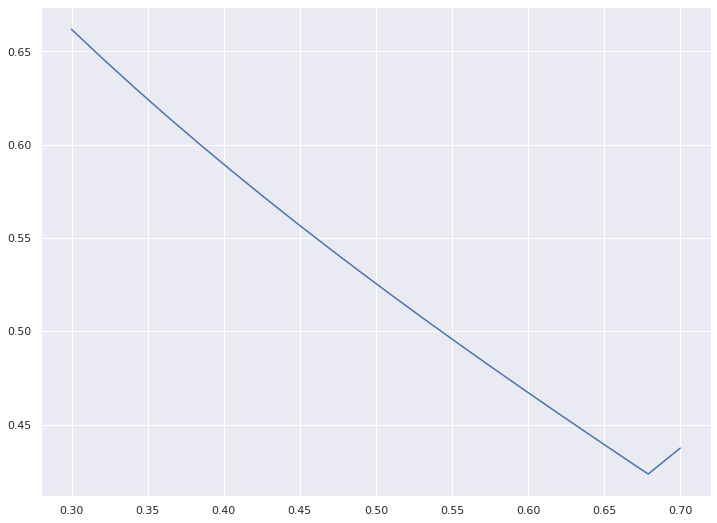

In [24]:
plt.plot(ts, thetas)